<a href="https://colab.research.google.com/github/phwangktw/data-course-sample/blob/main/Session3_Collaborative-based(user-based)_Recommendation_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session2: Content-based Recommendation Algorithm

## Step1. Packages import and utiltiets functions

*   `nltk` package used for text parsing.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import gzip, json
from os.path import exists
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
sns.set_style("whitegrid")

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(nltk.corpus.stopwords.words('english'))
def content_filter(text):
    # stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if (w.lower() not in stop_words) & (w.isalnum()) ]
    return content

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Step2. Download data

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)



--2022-01-03 20:30:49--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  8.16MB/s    in 1.8s    

2022-01-03 20:30:51 (8.16 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2022-01-03 20:30:51--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  6.02MB/s    in 1.6s    

202

## Step3. Parsing data

### Step3-1: Convert time format

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### Step3-2: Data preprocessing
(As same as [session1](https://github.com/phwangktw/data-course-sample/blob/main/Session1_Rule-based_Recommendation_Algorithm.ipynb))

*   Dropout the duplicated rows
*   Fill the blanks with `nan`
*   Parsing the `description` column for generating `rank_num` and `rank_category`
*   Regex expression for searching specific key words

In [ ]:
##Cleaning data (cited from: https://github.com/yuchiahung/data-course-sample/blob/main/hw1_Ana.ipynb)
##Peaking data firstly
metadata_clean = metadata.loc[metadata.astype(str).drop_duplicates().index]
metadata_clean.replace('', np.nan, inplace = True)


# clean column `rank` -> Parsing out to RankNum + RankCategory
metadata_clean['rank'] = metadata_clean['rank'].str.replace('&amp;', '&')
metadata_clean['rank'].fillna('0', inplace = True)
metadata_clean['rank_category'] = [re.search('in (.*) \(', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = [re.search('(.*) in .*', r).group(1) if r != '0' else None for r in metadata_clean['rank']]
metadata_clean['rank_num'] = metadata_clean['rank_num'].str.replace(',', '').astype(float)

# excluding category != 'Beauty & Personal Care'
metadata_clean = metadata_clean[metadata_clean.rank_category == 'Beauty & Personal Care']

# convert `price` to float
metadata_clean['price'].fillna('0', inplace = True)
metadata_clean['price'] = [re.search('\$(.*)', p).group(1) if re.search('\$(.*)', p) != None else None for p in metadata_clean['price']]
metadata_clean['price'] = metadata_clean['price'].str.replace(',', '').astype(float)

# drop useless columns
metadata_clean.drop(
    ['category', 'tech1', 'fit', 'tech2', 'date', 'similar_item', 'feature', 'main_cat', 'rank'], 
    axis = 1, 
    inplace = True
)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

### Step3-3: Analyze the distribution of the words
*   Problem statement:

The original texts in the `title` contain many redundant words such as *a the, are, not* ...etc, which will unavoidably raise the matrix/vector size in the calculation of `similarity_matrix` and the `tokenization`.
*   Solution:
`nltk` package is used to do:


1.   Filter out the stopwords: `content_filter(text)`
2.   Select words with occurance >1 to sufficiently represent the original text. (`N=15904`)

In [ ]:
metadata_titleOnly = metadata_clean[['asin','title']].reset_index().drop(['index'], axis=1)
metadata_titleOnly['title'] = metadata_titleOnly['title'].str.replace('&amp;', '')
wholeContent = ''
for i, a in enumerate(metadata_titleOnly.title):
    wholeContent += a + ' '

##TODO: filter out the numerical words (Ex. 8, 24...)
tokens = nltk.word_tokenize(wholeContent)
contentToken_filtered = content_filter(tokens)
rawBgs = nltk.ngrams(contentToken_filtered,1)
fdist = nltk.FreqDist(rawBgs)

keywordlist ={}
for k, v in fdist.items():                  
    keywordlist[k[0]] = v

Analysis of the distribution of keywords:


1.   Example words of the different occurring counts:


*   Counts=1: `Therapro, MEDIceuticals,  Cellagen,  Silks,  Solstice,  Violinists, menthol,  Gaba, atomiser,  70307,  PWDR,  ORCHID,  Introducing,  streamlined,  extend, patients, bed,  Interlude,  Frances,  Denney,  AROMATIC...`


*   Counts<=5: `Coloplast, Sween, Refinisher, DKNY, pr, Sinex, 190, cc, UVB, Boogie, Nacro, Franklin, Computer, 710, Defrizzant, Superstay, Son, Reflect, Diabetic, FIRE, tan, BREEZE, 230ml...`


*   Counts<=10: ` YSL, AB, Hero, Oak, Wisdom, Shaker, Cm, Victorias, Things, Cognac, Buds, Volcanic, Capri, Scene, Delight, Fleece, 100x, growth, beard, scalp, Siberian, Fuji, Revolution, Mosaic, PERFUME, Hada, Labo, Flax, Whisper, Character...`


*   Counts<=100: ` Genuine, Grips, Rocker, Hollywood, Carpet, Assortment, Alpha, Bottom, Tag, Hours, Clippers, King, Endurance, Smith, skin, Zinc, W, black, Sterile, Strip, 17, Second, Hask, Placenta, Treatments, VO5, Aroma, Sensual, Musk, Tinted...`


*   Counts>100: ` Eyelash, Lot, Ladies, Necklace, Bridal, Crown, Shaped, Ponytail, Curly, Costume, Clip, Wig, Extensions, Roller, Ball, Shape, Chain, Tool, Pcs, Vintage, Bracelet, Scarf, Resistant, TATTOO, Pearl, Bundle...`


2.   From the example word lists, we can see that the words with a single occurrence are too specific, which leads to no corresponding paired products.


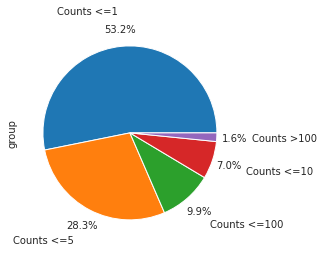

In [ ]:
#Check-purpose only
CountsDF = pd.DataFrame.from_dict(keywordlist, orient='index',columns=['Counts'])
#Control size of the keywords
CountsDF.describe()

# create a list of our conditions
conditions = [
    (CountsDF['Counts'] <= 1),
    (CountsDF['Counts'] <= 5),
    (CountsDF['Counts'] <= 10),
    (CountsDF['Counts'] <= 100),
    (CountsDF['Counts'] <= 10000)
    ]

# create a list of the values we want to assign for each condition
values = ['Counts <=1', 'Counts <=5', 'Counts <=10', 'Counts <=100', 'Counts >100']

# create a new column and use np.select to assign values to it using our lists as arguments
CountsDF['group'] = np.select(conditions, values)
CountsDF.group.value_counts().plot.pie(autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.4)
filterList = CountsDF[CountsDF['group']!='Counts <=1'].reset_index()['index'].str.lower().tolist()

### Step3-4: Text Parsing
After applying the word rule with more than 1 occurrence, the content size will effectively shrinkage and (assumably) keep the same information inside.

Example:


*   `Loud 'N Clear&trade; Personal Sound Amplifier` 
  
  => `Loud Personal Sound Amplifier`


*   `Hello Kitty LALA Lovely Kids Girls Summer Slippers Shoes Beach Pool Black US size 3` 

  => `Hello Kitty Lovely Kids Girls Summer Slippers Shoes Beach Pool Black US size`

*   `Norelco 5655X Deluxe Advantage Wet/Dry Cordless Rechargeable Men's Shaver`

  => `Norelco Deluxe Advantage Cordless Rechargeable Shaver`

In [ ]:
#Text Parsing
#Step1: Parsing title to KeyWords ONLY
keyCounts = 0
metadata_titleOnly['titleNew'] = ""
for i, a in enumerate(metadata_titleOnly.title):
    a_Raw = a.split()
    resultwords  = [word for word in a_Raw if word.lower() in filterList]
    result = ' '.join(resultwords)    
    if (len(result) != 0):
        metadata_titleOnly.loc[i, 'titleNew'] = result
        keyCounts += 1

keyWordCoverage = keyCounts/metadata_titleOnly.shape[0]
print(f'Key words coverage: {round(keyWordCoverage, 4)}')

Key words coverage: 0.9974


99.74% of the products will "at least have 1 value" in the vectorized text vector. Although some of the information might be lost, the gain of the computational resource is more beneficial.

### Step3-5: TF-IDF Matrix Generation
- csr_matrix() (Compressed Sparse Row Matrix): `TfidfVectorizer` is used for TF-IDF generation.
  

In [ ]:
# 計算商品用標題所表示的 tfidf 矩陣
#df_test = metadata_titleOnly.drop_duplicates('titleNew')
#If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
#Only applies if analyzer == 'word'.
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(metadata_titleOnly['titleNew'])

matrix_density = tfidf_matrix.getnnz()/(tfidf_matrix.shape[0]*tfidf_matrix.shape[1])
print(f'Matrix density: {round(matrix_density, 4)}')

Matrix density: 0.0006


### Step3-6: Similarity Calculation (based on cosine_similarity)

#### Example1:


*   Original Items: Hello Kitty Lovely Kids Girls Summer Slippers Shoes Beach Pool<br>
<img src='https://drive.google.com/uc?id=1a41ZqiFONnnd6iHH6CMcG_qcYL3fiagi' width="500" height="300">
*   Real recommendation from Amazon website
<img src='https://drive.google.com/uc?id=1RjoFVFBf60SpwKsT_H8kAesGS0xHDVM7' width="800" height="175">
*   Recommendation from Cosine-similarity matrix


    1.   Licensed Hello Kitty Slippers white medium size
    2.   Hello Kitty Sparkle Necklace Girls
    3.   Hello Kitty Comb
<img src='https://drive.google.com/uc?id=1U4DpDwxLCpYtCqIL_808MPcoKPjFiMz8' width="600" height="175"><br>

#### Example2:


*   Original Items: Norelco Deluxe Advantage Cordless Rechargeable Shaver<br>
<img src='https://drive.google.com/uc?id=1khxEHt_5whtMN57DEl9_xtutLPRPpr3e' width="500" height="300">
*   Real recommendation from Amazon website
<img src='https://drive.google.com/uc?id=15-y1oaB5CVlAbtybDTf_TsW6FwOYOl-u' width="800" height="175">
*   Recommendation from Cosine-similarity matrix


    1.   Norelco Deluxe Advantage Cordless Razor
    2.   Philips Norelco Rechargeable Cordless Shaver
    3.   Philips Norelco Cordless Rechargeable Shaver

<img src='https://drive.google.com/uc?id=18QPiDdIGXG5kc6La95G9TluZGRgJKg-L' width="600" height="175"><br>

#### Example3:
*   Original Items: Crest Toothbrush Sesame Street<br>
<img src='https://drive.google.com/uc?id=1TbQ3KMqp5bvIQMi4XQIpOzL2g_5ctaFw' width="500" height="300">
*   Real recommendation from Amazon website
<img src='https://drive.google.com/uc?id=1od03e_xH-Y3SDNaKBgm2h3POJyH34PDm' width="800" height="175">
*    Recommendation from Cosine-similarity matrix


1.   Sesame Street Elmo Clean Kit
2.   Sesame Street Cookie Monster Elmo Hand Soap Set

<img src='https://drive.google.com/uc?id=1pJyTkrSRKxP9-8HoXxF_XhHGsUqfOa44' width="400" height="175"><br>

In [ ]:
# 計算商品間的相似程度
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(metadata_titleOnly.index,index = metadata_titleOnly['asin'])

testList = [11,21,101,1001,5000,10001]

for i in testList:
    tempDF = pd.DataFrame(similarity_matrix[i,:]).sort_values(by=[0],ascending=False)
    
    index = tempDF.index
    condition = tempDF[0] != 0
    tempDF_list = index[condition].tolist()
    for j in range(3):
        if j==0:
            print('\nOriginal item: '+metadata_titleOnly['titleNew'][tempDF_list[j]])
        else:
            print('\nRecommended item: '+metadata_titleOnly['titleNew'][tempDF_list[j]])
    print('------------------------------')


Original item: Hello Kitty Lovely Kids Girls Summer Slippers Shoes Beach Pool Black US size 3

Recommended item: Licensed Hello Kitty Slippers white medium size

Recommended item: Hello Kitty Sparkle Necklace Girls
------------------------------

Original item: Norelco Deluxe Advantage Cordless Rechargeable Shaver

Recommended item: Norelco Deluxe Advantage Cordless Razor

Recommended item: Philips Norelco Cordless Rechargeable Shaver
------------------------------

Original item: Crest Toothbrush Sesame Street

Recommended item: Sesame Street Elmo Clean Kit

Recommended item: Sesame Street Cookie Monster Elmo Hand Soap Set
------------------------------

Original item: Pre de Provence Artisanal French Soap Bar Enriched Shea Smooth Rich Lather Honey Almond

Recommended item: Pre de Provence Artisanal French Soap Bar Enriched Shea Smooth Rich Lather Milk

Recommended item: Pre de Provence Artisanal French Soap Bar Enriched Shea Smooth Rich Lather Raspberry
-----------------------------

## Step4: Algorithm Model Implementation
### Step4-1: Details of the content-based algorithm 


*   Step1: Iteratively examines the recommended items with respect to each history of purchased items.
*   Step2: Generate topK items with the highest similarity score.



In [ ]:
# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (metadata_titleOnly['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦 (KNN average the purchase history)
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

### Step4-2: Split time frame for testing and validation purpose

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

### Step4-3: Content-based Model setup 


*   Stpe1: Set a fixed number (`k1=5`) for the content-based recommendation, and others for the rule-based recommendation.
*   Step2: Examine the user whether or not the history purchases exist.
*   Step3: Combine both content-based and rule-based results as the users' recommendations.

 

In [ ]:
def recommender_content1(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
       
    for user in users:
        content_recom = []
        rule_recom = []
        k1 = 5
        ### UserID convert to purchase history
        ## Content-based 
        ### Ensure the user has existing purchase (comment) history
        existHistory = metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist()
        if len(existHistory) > 0:
            content_recom = recommend_items(existHistory,k1)
        
        # Popular products (recommend `k_left` products)
        k_left = k - len(content_recom)
        ## Best seller (by rating data) & highest rating products (recommend `k` product)
        products_rating = training_data[training_data.DATE >= '2017-09-01'].groupby('asin')[['overall']].agg(['mean', 'count'])
        products_rating.columns = products_rating.columns.droplevel(0)
        rule_recom = products_rating.sort_values(by = ['count', 'mean'], ascending = False).index.tolist()[:k_left]
        
        
        # concat all the item lists (k2 by rank, k3 by rating, others by sales)
        user_recom = content_recom + rule_recom
        recommendations[user] = user_recom

    return recommendations

### Step4-4: Base Model setup 
Base case setup as the rule-based algorithm of the most K popular products of the recent year (see as Session1). 

In [ ]:
#Rule1: A year-based recommendation
def recommender_base(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    ## Best seller (by rating data) & highest rating products (recommend `k` product)
    products_rating = training_data[training_data.DATE >= '2017-09-01'].groupby('asin')[['overall']].agg(['mean', 'count'])
    products_rating.columns = products_rating.columns.droplevel(0)
    best_seller_lst = products_rating.sort_values(by = ['count', 'mean'], ascending = False).index.tolist()[:k]

    recommendations = {user: best_seller_lst for user in users}
    return recommendations

### Step4-5: Evaluation Algorithm and the Results

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

rcListRule1 = recommender_content1(ratings_trainings, users)
rcListBase = recommender_base(ratings_trainings, users)

scoreContent = evaluate(ratings_testings_by_user, rcListRule1)
scoreBase = evaluate(ratings_testings_by_user, rcListBase)
# Evaluation scores
print(f'Rule1: \n{round(scoreContent, 4)}')
print(f'Base_case: \n{round(scoreBase, 4)}')
print(f'Improvemnt of Content-based method: \n{round(100*(scoreContent-scoreBase)/scoreContent, 1)} %')

Rule1: 
0.1068
Base_case: 
0.0983
Improvemnt of Content-based method: 
7.9 %


## Step5: Discussions of obstacles

The reasons that we cannot generate significant score improvements are described as follows:
*   Limiting testing users (38/584=6.5%) have purchase (comment) historical records.
*   The average content-based score is really low, which reflects that the majority of products the user new bought are irrelated to its history purchased.



In [ ]:
userWithHistory = []
for user in users:
    existHistory = metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist()
    if len(existHistory) != 0:
        userWithHistory.append(user)
userWithHistoryAns = {}
for i in range(len(userWithHistory)):
  userWithHistoryAns[userWithHistory[i]] = ratings_testings_by_user[userWithHistory[i]]

In [ ]:
rcListRule2 = recommender_content1(ratings_trainings, userWithHistory)
# Evaluation scores
print(f'Rule1: \n{round(evaluate(userWithHistoryAns, rcListRule2), 4)}')

Rule1: 
0.0119


In [ ]:
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (metadata_titleOnly['asin'].iloc[item_indices].tolist())
    except:
        return []

In [ ]:
def recommend_item_lookup(item_input, item_ans):
    try:
        resultString = ''
        item_index = mapping[item_input]
        item_ans_index = mapping[item_ans]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        i_rank = 0
        while (item_ans_index != similarity_score[i_rank][0]):
            i_rank +=1
            
        resultString = 'Acual bought item is ranked as: '+str(i_rank)+' with score: '+str(round(similarity_score[i_rank][1],4))
        return resultString
    except:
        return []

testUsers = ['A1UAOE8KO7Q1DZ', 'A1WEFBEJ7OHSVZ', 'A1WSZED2O5MA5T', 'A28E3FNV1BYC94', 'A29834GBB4DOP1']
for user in testUsers:
    asin2titleNew = []
    actualtitleNew = []
    existHistory = metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist()

    for historyItem in existHistory:
        asin2titleNew.append(metadata_titleOnly[metadata_titleOnly['asin']==historyItem]['title'].iloc[0])
        realBoughtList = userWithHistoryAns[user]
        for realBoughtItem in realBoughtList:
            actualtitleNew.append(metadata_titleOnly[metadata_titleOnly['asin']==realBoughtItem]['title'].iloc[0])
            resultStr = recommend_item_lookup(historyItem, realBoughtItem)
    for j in asin2titleNew:
        print('\n'+user+' once bought: '+j)
    for k in actualtitleNew:
        print('\n'+user+' now bought: '+k)
    print('\n'+resultStr)
    print('------------------------------')


A1UAOE8KO7Q1DZ once bought: H2O+ Sea Salt Hydrating Body Lotion - 250ml/8.5oz

A1UAOE8KO7Q1DZ now bought: Algenist Genius Ultimate Anti-Aging Eye Cream w/ Alguronic Acid (.17 oz) Mini Travel Size

Acual bought item is ranked as: 29267 with score: 0.0
------------------------------

A1WEFBEJ7OHSVZ once bought:  Fairy Tales Tangle Tamer Static Free &nbsp;Detangling Spray for Kids - 12 oz

A1WEFBEJ7OHSVZ now bought: Cantu Natural Hair Wave Whip Curling Mousse,8.4 oz

Acual bought item is ranked as: 3261 with score: 0.0316
------------------------------

A1WSZED2O5MA5T once bought: Helen of Troy 1579 Tangle Free Hot Air Brush, White, 3/4 Inch Barrel

A1WSZED2O5MA5T now bought: NICKA K Vivid Matte Lipstick NMS07 Black

Acual bought item is ranked as: 25702 with score: 0.0
------------------------------

A28E3FNV1BYC94 once bought: Vibrant Bright Skin Lightening Cream by Healthy Vibes (2 oz) - Skin Whitening Treatment for Birthmarks, Blemishes, Pigmentation - Safe for Sensitive Areas - Natu

#### Examples of our testing users

1.   Body Lotion vs. Anti-Aging Eye Cream<br>
<img src='https://drive.google.com/uc?id=1xx-Grpx6Y3XyomJhtLVlzwre907abQRq' width="250" height="175"><br>
2.   Detangling Spray vs. Hair Wave Whip Curling Mousse<br>
<img src='https://drive.google.com/uc?id=1H6Pgz7wLa6S7RsSAQyEv95Z4JaBbGXSa' width="250" height="175"><br>
3.   Tangle Free Hot Air Brush vs. Lipstick<br>
<img src='https://drive.google.com/uc?id=1Tgyz2SCNcj_w3ZPohMXppLlfYQ21otOg' width="250" height="175"><br>
4.   Skin Lightening Cream vs. Butt Enhancement Cream<br>
<img src='https://drive.google.com/uc?id=1uUC0HGqW2mTSFSWmhSSezdodT9WSVr5e' width="250" height="175"><br>


